In [1]:
import copy
import numpy as np
import tensorflow as tf

# Simple RL
from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

# Torch
import torch
import torch.optim as optim
from torch import FloatTensor
from torch.autograd import Variable

# https://github.com/pandas-profiling/pandas-profiling/issues/68
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib inline

# MLIRL [1]

In [3]:
# Modified to handle given goal scenario.
def MLIRL(state_trajectories, action_trajectories, states, state_features,
              actions, trans_dict, optimizer_fn, n_iter=1, n_vi_iter=1,
              gamma=0.99, boltzmann_beta=1., dtype=torch.float64,
              print_interval=1, grad_eps=1e-3, w_init_scheme=None, w_init=None,
              goal_is_given=False):
    
    assert w_init_scheme in ["random", "zeros", "custom"]
    assert len(states) == len(state_features)
    
    nS = len(states)
    nA = len(actions)
    state_features = torch.from_numpy(state_features).type(dtype)
    feature_dim = state_features.shape[1]
    state_to_idx = {s:idx for idx,s in enumerate(states)}
    action_to_idx = {a:idx for idx,a in enumerate(actions)}
    softmax = torch.nn.Softmax(dim=0)
    
    # Reward parameters
    if w_init_scheme == "custom":
        assert w_init is not None
        w = Variable(torch.Tensor(w_init).type(dtype), requires_grad=True)
    elif w_init_scheme == "zeros":
        w = Variable(torch.zeros(feature_dim, 1).type(dtype), requires_grad=True)
    elif w_init_scheme == "random" or w_init_scheme is None:
        w = Variable(torch.Tensor(feature_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
        
    # Optimization variables
    optimizer = optimizer_fn([w])
    
    for _iter in range(n_iter):
        
        loss = 0
        for traj_idx, state_trajectory in enumerate(state_trajectories):
            
            _goal_state = state_trajectory[-1]
            
            # Stochastic Policy
            Pi = torch.ones(nS, nA, dtype=dtype) / nA
            # Reward^~
            R = torch.mm(state_features, w)            
            # Value
            V = R[:,0].clone()
            # Q value
            Q = R.repeat(1,nA).clone()
            
            if goal_is_given:
                # Assume goal state is given (we want V[goal]=0 and absorbing, so that we learn navigation cost features not navigation to the goal.)
                V[state_to_idx[_goal_state]] = 0
                
            for _v_iter in range(n_vi_iter):
                for s_idx, s in enumerate(states):

                    # Check if state is terminal (stop leaking values back to non-goal state space)
                    if s.is_terminal() or (goal_is_given and s == _goal_state):
                        continue

                    phi_s = state_features[s_idx]
                    for a_idx, a in enumerate(actions):

                        Q[s_idx, a_idx] = R[s_idx]
                        for s_prime in trans_dict[s][a]:
                            Q[s_idx, a_idx] += gamma * trans_dict[s][a][s_prime] * V[state_to_idx[s_prime]].clone()
                        Pi[s_idx, :] = softmax(boltzmann_beta * Q[s_idx,:].clone())
                        V[s_idx] = Pi[s_idx, :].clone().dot(Q[s_idx,:].clone())
                        
            for point_idx, state in enumerate(state_trajectory[:-1]):
                s_idx = state_to_idx[state]
                a_idx = action_to_idx[action_trajectories[traj_idx][point_idx]]
                loss -= torch.log(Pi[s_idx,a_idx])
                
        optimizer.zero_grad()
        loss.backward()
        grad_l2 = w.grad.norm(2)
        if _iter % print_interval == 0 or _iter == n_iter-1:
            print("Iter: {:04d}, loss: {:012.6f}, w: [{}], dw: [{}], l2(dw): {}".format(
                _iter, loss, ' '.join("{:+10.8f}".format(v) for v in w[:,0]), ' '.join("{:+10.9f}".format(v) for v in -w.grad[:,0]), grad_l2))
            
        if grad_eps is not None and grad_l2 < grad_eps:
            print("Converged at iteration {}.".format(_iter))
            break
            
        optimizer.step()
    return w, R, Pi, V, Q, loss

# Experiments

In [4]:
def get_action(state, n_state):
    dx = n_state[0] - state[0]
    dy = n_state[1] - state[1]
    if dx > 0 and dy == 0: return "right"
    elif dx > 0 and dy > 0: return "up_right"
    elif dx == 0 and dy > 0: return "up"
    elif dx < 0 and dy > 0: return "up_left"
    elif dx < 0 and dy == 0: return "left"
    elif dx < 0 and dy < 0: return "down_left"
    elif dx == 0 and dy < 0: return "down"
    elif dx > 0 and dy < 0: return "down_right" 
    else: return "stay" #dx == 0 and dy == 0:
    
def get_actions_from_state_traj(state_traj):
    return [get_action(state_traj[i], state_traj[i+1]) for i in range(len(state_traj)-1)]

def map_v_to_grid(states, V, nvmdp):
    V_grid = np.zeros((nvmdp.height, nvmdp.width))
    for i in range(len(states)):
        r, c = nvmdp._xy_to_rowcol(states[i].x, states[i].y)
        V_grid[r,c] = V[i]
    return V_grid

def compute_new_value(results):
    nvmdp_ = copy.deepcopy(results["nvmdp"])
    living_rewards_pred = np.array([nvmdp_.cell_type_feature(i) for i in nvmdp_.living_cell_ids]).dot(results["w"].data).reshape(-1,1).tolist()
    if len(nvmdp_.goal_cell_ids) == 0:
        goal_rewards_pred = []
    else:
        goal_rewards_pred = np.array([nvmdp_.cell_type_feature(i) for i in nvmdp_.goal_cell_ids]).dot(results["w"].data).reshape(-1,1).tolist()
    nvmdp_._reset_rewards(living_rewards_pred, goal_rewards_pred)
    return nvmdp_.get_value_grid()

def MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=True, figsize=(10,10), print_interval=1):
    
    if "goal_locs" not in irl_problem:
        irl_problem["goal_locs"] = []
        irl_problem["goal_types"] = []
        irl_problem["goal_types"] = []
        
        
    # Navigation MDP with no goals
    nvmdp = NavigationMDP(width=irl_problem["width"], height=irl_problem["height"],
                          living_cell_types=irl_problem["cell_types"],
                          living_cell_rewards=[0]*len(irl_problem["cell_types"]),
                          living_cell_distribution="manual",
                          living_cell_locs=irl_problem["cell_locs"],
                          goal_cell_locs=irl_problem["goal_locs"],
                          goal_cell_types=irl_problem["goal_types"],
                          goal_cell_rewards=[0]*len(irl_problem["goal_types"]))
    # Visualize Grid
    if disp_grid:
        nvmdp.visualize_grid(nvmdp.state_space, trajectories=irl_problem["traj_states"], 
                             state_space_cmap=plt.cm.viridis, end_marker="*k", goal_marker_sz=10, title=irl_problem["title"])
    
    # MLIRL Inputs
    phi = lambda s: nvmdp.feature_at_state(s, "indicator", incl_cell_distances=False, incl_goal_indicator=True, incl_goal_distances=False, normalize_distance=False)
    phi_loc = lambda x,y: nvmdp.feature_at_loc(x, y, "indicator", incl_cell_distances=False, incl_goal_indicator=True, incl_goal_distances=False, normalize_distance=False)
    states = nvmdp.get_states()
    actions = nvmdp.get_actions()
    state_features = np.asarray([phi(s) for s in states])
    cell_features = np.asarray([[phi_loc(*nvmdp._rowcol_to_xy(row,col)) for col in range(nvmdp.width)] for row in range(nvmdp.height)])
    T = nvmdp.get_trans_dict()
    # MLIRL
    print("Training...\n \t\t\t\t \t {}  \t {} ".format(' '.join("{:11}".format(v) for v in nvmdp.cell_types), ' '.join("{:11}".format(v) for v in nvmdp.cell_types)))
    w, _, Pi, V, Q, loss = MLIRL(irl_problem["traj_states"], irl_problem["traj_actions"], states, state_features, actions, T, **mlirl_params, print_interval=print_interval)
    print("Done.")
    # Recovered Reward
    R = cell_features.dot(w.data)[:,:,0]
    # Map values to grid
    # V_grid = map_v_to_grid(states, V, nvmdp)
    
    # Display results
    if disp_results:
        display_irl_results(nvmdp, irl_problem["traj_states"], R, V_grid, title, figsize)
    return dict(w=w, R=R, Pi=Pi, V=V, Q=Q, nvmdp=nvmdp, phi=phi, phi_loc=phi_loc)

def display_irl_results(nvmdp, tau_s, recovered_R, V=None, title="", rewards_cmap=None, figsize=(16,8), r_fig_suffix=""):
    
    plt.figure(figsize=figsize)
    nvmdp.visualize_grid(nvmdp.state_space, new_fig=False, subplot_str="221", trajectories=tau_s, 
                         state_space_cmap=True, show_colorbar=False, end_marker="*k", title=title)
    nvmdp.visualize_grid(recovered_R, new_fig=False, subplot_str="222", cmap=rewards_cmap, state_space_cmap=False,
                         show_colorbar=True, text_values=recovered_R, text_size=10, title="MLIRL Recovered R" + r_fig_suffix)
    if V is not None:
        nvmdp.visualize_grid(V, new_fig=False, subplot_str="223", state_space_cmap=False, show_colorbar=True, text_values=V, text_size=10, title="Value")

### Michael Littman MDP (RL class)
Ref: https://www.youtube.com/watch?v=h7uGyBcIeII&t=2s

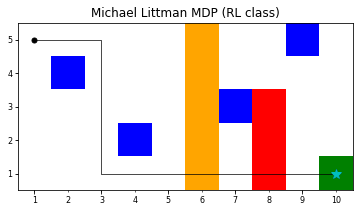

Training...
 				 	 white       blue        orange      red         green        	 white       blue        orange      red         green       
Iter: 0000, loss: 00018.021828, w: [+0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000], dw: [-25.401247025 -10.550214767 -1.012973070 +1.652733207 +7.062345982], l2(dw): 28.463394165039062
Iter: 0001, loss: 00016.547886, w: [-0.25401247 -0.10550214 -0.01012973 +0.01652733 +0.07062346], dw: [+24.326885223 -11.760028839 -39.709419250 -11.613518715 +7.751221180], l2(dw): 50.01888656616211
Iter: 0002, loss: 00010.662881, w: [-0.23681471 -0.31699932 -0.41623938 -0.08489852 +0.21099055], dw: [-14.045268059 -4.754020214 +3.124968052 -2.407294512 +3.616341829], l2(dw): 15.764158248901367
Iter: 0003, loss: 00008.766708, w: [-0.35942125 -0.55171698 -0.74632597 -0.19940576 +0.37137443], dw: [-13.705199242 -2.203537941 +3.836493015 -0.158732533 +2.446204185], l2(dw): 14.608759880065918
Iter: 0004, loss: 00006.680305, w: [-0.60322493 -0.77948105 -

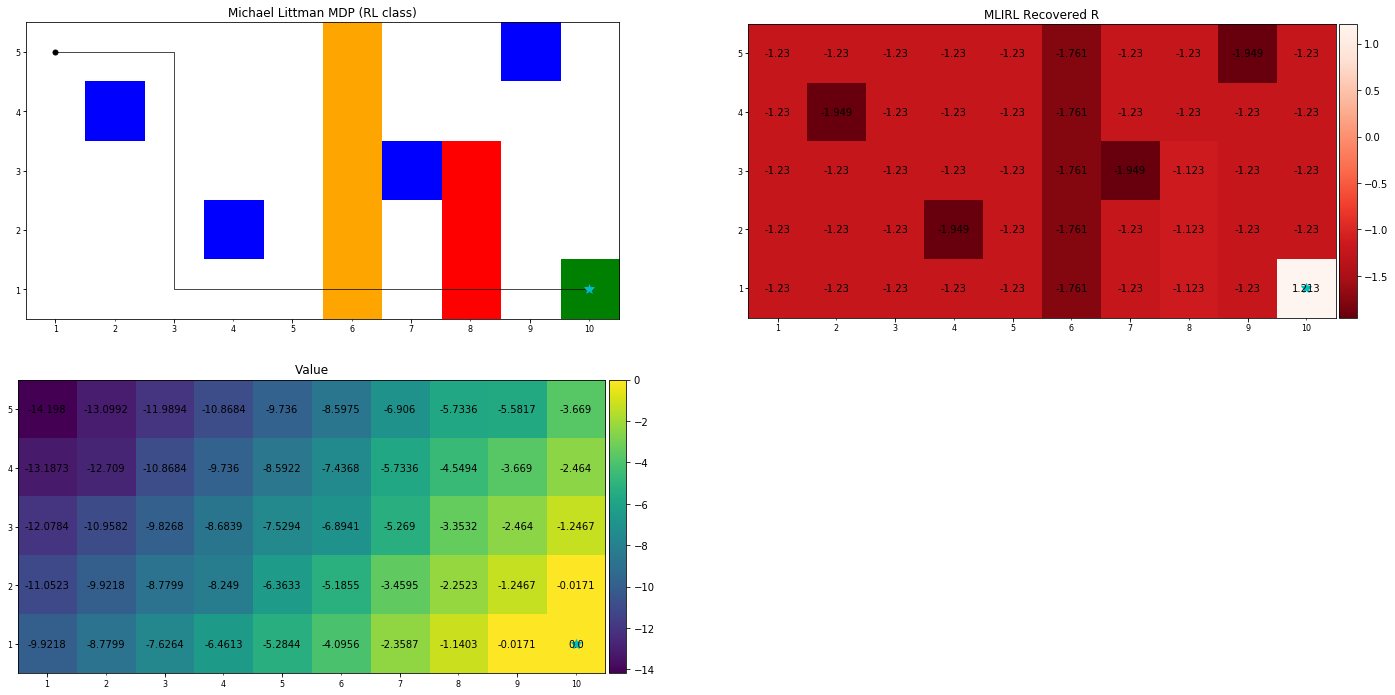

In [5]:
mlirl_params = dict(
    n_iter = 10,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 10.,
    w_init_scheme = "zeros",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', 'blue', "orange", "red"],
    cell_locs = [np.inf, [(2,4), (4,2), (7,3), (9,5)], [(6,i) for i in range(1,6)], [(8,i) for i in range(1,4)]],
    goal_types = ["green"],
    goal_locs = [(10, 1)],
    tau_s = [[(1,5),(2,5)] + [(3,i) for i in range(5,0,-1)] + [(i,1) for i in range(4,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Michael Littman MDP (RL class)",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), compute_new_value(results).round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r, figsize=(24,12))

### Yellow Magnet
Expected: 0 gradients, 0 change in params

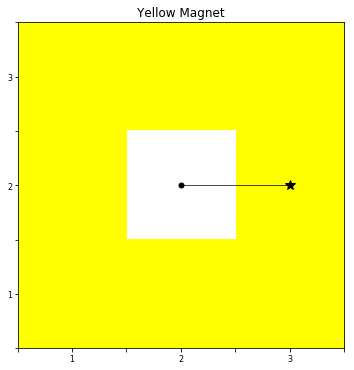

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00001.386294, w: [+0.00000000 +0.00000000], dw: [+0.000000103 -0.000011563], l2(dw): 1.1563763109734282e-05
Iter: 0001, loss: 00001.386294, w: [+0.00000000 -0.00000012], dw: [+0.000000197 -0.000012755], l2(dw): 1.2756917385559063e-05
Iter: 0002, loss: 00001.386294, w: [+0.00000000 -0.00000035], dw: [-0.000000244 -0.000010133], l2(dw): 1.013573637465015e-05
Iter: 0003, loss: 00001.386294, w: [+0.00000000 -0.00000066], dw: [+0.000000112 -0.000010729], l2(dw): 1.072941995516885e-05
Iter: 0004, loss: 00001.386294, w: [+0.00000001 -0.00000104], dw: [-0.000000185 -0.000011325], l2(dw): 1.1326389540045056e-05
Done.


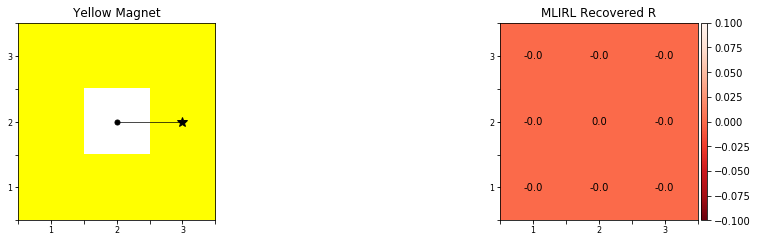

In [6]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 10.,
    w_init_scheme = "zeros",
    grad_eps = 1e-5,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.) # 0 L2 penalty, so that we don't see unwanted gradients
)

mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [[(2,2)], np.inf],
    tau_s = [[(2,2),(3,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Yellow Magnet",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), None, irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

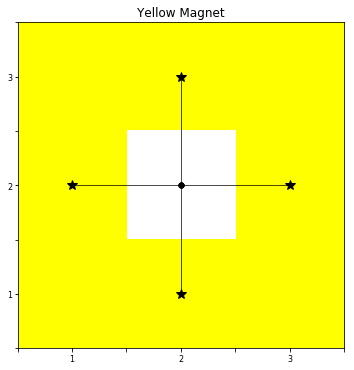

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00005.545177, w: [+0.00000000 +0.00000000], dw: [+0.000000152 -0.000009418], l2(dw): 9.418758054380305e-06
Converged at iteration 0.
Done.


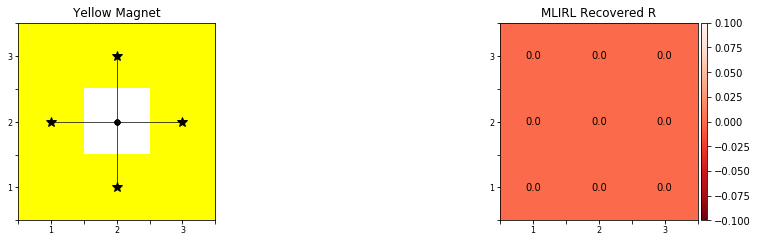

In [7]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 10.,
    w_init_scheme = "zeros",
    grad_eps = 1e-5,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.) # 0 L2 penalty, so that we don't see unwanted gradients
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [[(2,2)], np.inf],
    tau_s = [[(2,2),(3,2)], [(2,2),(2,1)], [(2,2),(2,3)], [(2,2),(1,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Yellow Magnet",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), None, irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Contradiction

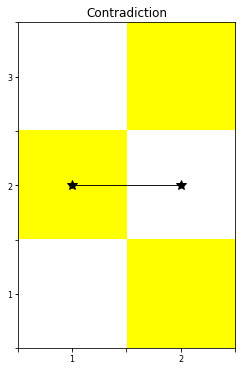

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00002.772589, w: [+0.00000000 +0.00000000], dw: [-0.000004649 -0.000002861], l2(dw): 5.458952273329487e-06
Converged at iteration 0.
Done.


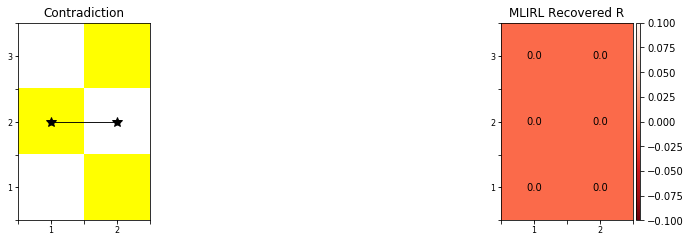

In [8]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 10.,
    w_init_scheme = "zeros",
    grad_eps = 1e-5,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.) # 0 L2 penalty, so that we don't see unwanted gradients
)
mdp_params = dict(
    width = 2,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [np.inf, [(1,2),(2,3),(2,1)]],
    tau_s = [[(2,2),(1,2)], [(1,2),(2,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Contradiction",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), None, irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

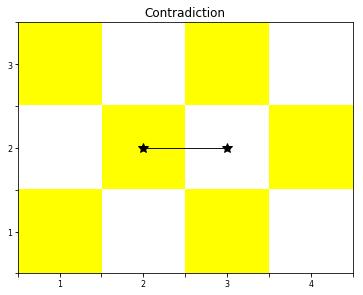

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00002.772589, w: [+0.00000000 +0.00000000], dw: [-0.000003338 +0.000001073], l2(dw): 3.5060504615103127e-06
Converged at iteration 0.
Done.


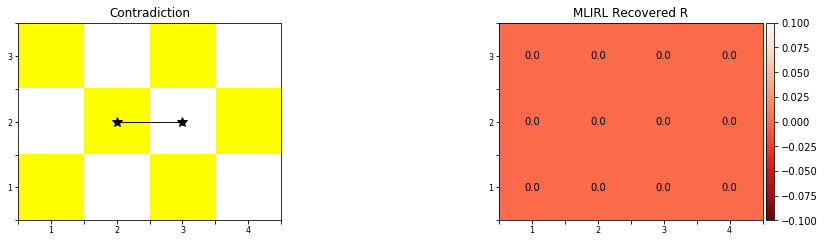

In [9]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 10.,
    w_init_scheme = "zeros",
    grad_eps = 1e-5,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.) # 0 L2 penalty, so that we don't see unwanted gradients
)
mdp_params = dict(
    width = 4,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [np.inf, [(1,3),(1,1),(2,2),(3,3),(3,1),(4,2)]],
    tau_s = [[(3,2),(2,2)], [(2,2),(3,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Contradiction",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), None, irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

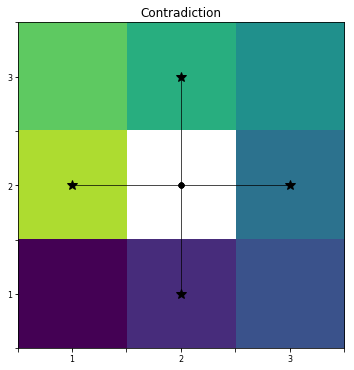

Training...
 				 	 white                 0           1           2           3           4           5           6           7  	 white                 0           1           2           3           4           5           6           7 
Iter: 0000, loss: 00005.545177, w: [+0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000], dw: [+0.000000152 +0.000000596 +0.000007629 -0.000001431 -0.000011444 -0.000000000 -0.000003815 -0.000000954 -0.000000238], l2(dw): 1.439158950233832e-05
Converged at iteration 0.
Done.


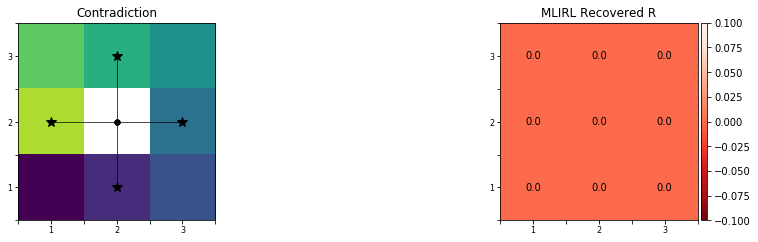

In [10]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 10.,
    w_init_scheme = "zeros",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.) # 0 L2 penalty, so that we don't see unwanted gradients
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white'] + list(range(0,8)),
    cell_locs = [[(2,2)], [(1,1)], [(2,1)], [(3,1)], [(3,2)], [(3,3)], [(2,3)], [(1,3)], [(1,2)]],
    tau_s = [[(2,2),(3,2)], [(2,2),(2,3)], [(2,2),(1,2)], [(2,2),(2,1)]]
)
irl_problem = dict(
    mdp_params, 
    title="Contradiction",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), None, irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Vertical Spread
Expected: R(white) > R(red)

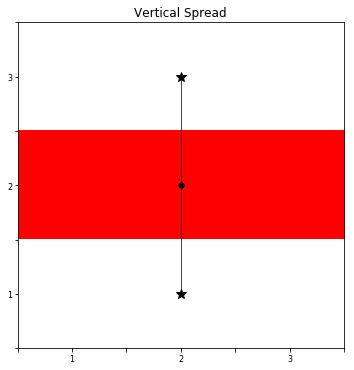

Training...
 				 	 white       red          	 white       red         
Iter: 0000, loss: 00002.882592, w: [-0.00587808 +0.00476966], dw: [+10.659868240 -10.659864426], l2(dw): 15.07532787322998
Iter: 0001, loss: 00001.706208, w: [+0.10077938 -0.10187668], dw: [+2.297135830 -2.297128677], l2(dw): 3.2486355304718018
Iter: 0002, loss: 00001.442358, w: [+0.21873467 -0.21981090], dw: [+0.427210331 -0.427135319], l2(dw): 0.6041135787963867
Iter: 0003, loss: 00001.396714, w: [+0.32697916 -0.32802495], dw: [+0.082229137 -0.082186207], l2(dw): 0.11625920981168747
Iter: 0004, loss: 00001.388603, w: [+0.42195171 -0.42295921], dw: [+0.018392563 -0.018398371], l2(dw): 0.02601511962711811
Done.


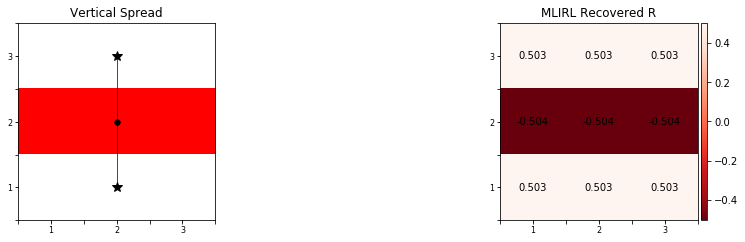

In [11]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 10.,
    w_init_scheme = "random",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'red'],
    cell_locs = [np.inf, [(i,2) for i in range(1,4)]],
    tau_s = [[(2,2),(2,3)], [(2,2),(2,1)]]
)
irl_problem = dict(
    mdp_params, 
    title="Vertical Spread",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), None, irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Speed Bump
Expected: R(green) = max(R), R(speed_bump) = min(R).

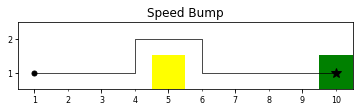

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00015.405248, w: [+0.01698453 -0.00021256 -0.00087012], dw: [-7.751668930 -4.988061905 +12.739749908], l2(dw): 15.724832534790039
Iter: 0001, loss: 00010.701589, w: [-0.06070200 -0.05009106 +0.12653607], dw: [-17.442594528 -4.945724964 +22.388345718], l2(dw): 28.808719635009766
Iter: 0002, loss: 00008.423770, w: [-0.30443880 -0.14393803 +0.46381974], dw: [+9.560131073 -7.602181435 -1.958094954], l2(dw): 12.37026309967041
Iter: 0003, loss: 00009.346716, w: [-0.42515624 -0.30298275 +0.74315590], dw: [+11.645890236 -7.945351124 -3.700592279], l2(dw): 14.575655937194824
Iter: 0004, loss: 00008.015388, w: [-0.41309145 -0.52254665 +0.95012093], dw: [+13.627630234 -9.935845375 -3.691786528], l2(dw): 17.264490127563477
Done.


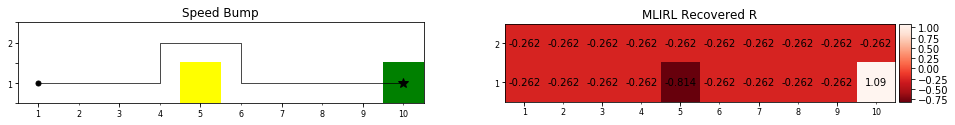

In [12]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 10.,
    w_init_scheme = "random",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 10,
    height = 2,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(5,1)], [(10,1)]],
    tau_s = [[(i,1) for i in range(1,5)] + [(4,2), (5,2), (6,2)] + [(i,1) for i in range(6,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Speed Bump",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), None, irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Ripples
Expected: R(green) = max(R), Increase in R(bump) values as we go from left to right.

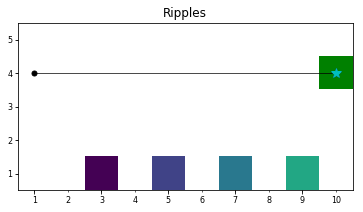

Training...
 				 	 white                 0           1           2           3 green        	 white                 0           1           2           3 green       
Iter: 0000, loss: 00012.476649, w: [+0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000], dw: [-34.228019714 -0.593459964 -0.408209950 -0.332686871 -0.218336254 +7.156147003], l2(dw): 34.977779388427734
Iter: 0001, loss: 00008.797589, w: [-0.34228018 -0.00593460 -0.00408210 -0.00332687 -0.00218336 +0.07156147], dw: [+17.750963211 -34.617370605 -2.861403942 -9.802909851 +1.613845706 +5.586025238], l2(dw): 40.63928985595703
Iter: 0002, loss: 00006.155302, w: [-0.46939993 -0.35739008 -0.03632921 -0.10431689 +0.01201190 +0.19111143], dw: [+12.608292580 -2.564079046 -30.342422485 -0.363850206 -0.821473360 +4.297394276], l2(dw): 33.248775482177734
Iter: 0003, loss: 00001.925327, w: [-0.45303077 -0.69576693 -0.36841252 -0.19780323 +0.01645279 +0.33976924], dw: [-4.299563885 +0.036360625 -0.915362000 -0.98662

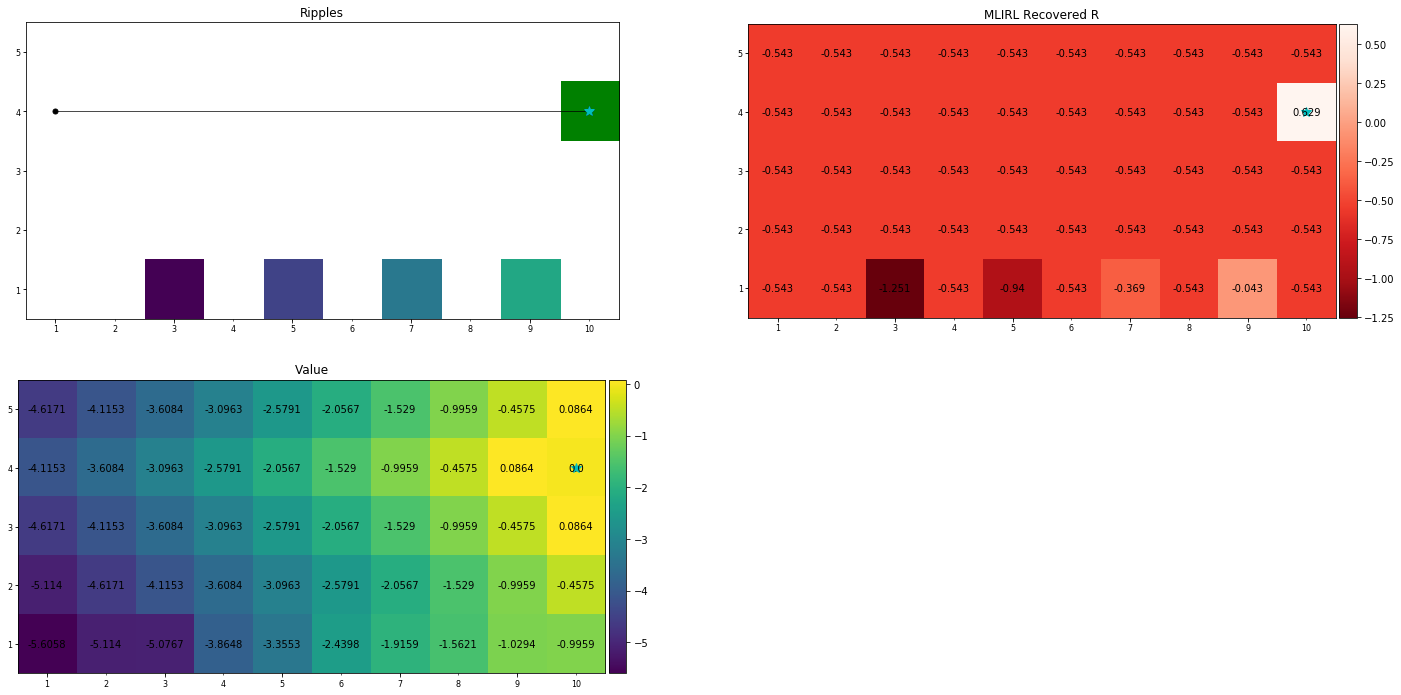

In [13]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 10.,
    w_init_scheme = "zeros",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
yi = 4
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white'] + list(range(4)),
    cell_locs = [np.inf, [(3,1)], [(5,1)], [(7,1)],[(9,1)]],
    tau_s = [[(i,yi) for i in range(1,11)]],
    goal_types=["green"],
    goal_locs=[(10,yi)],
)
irl_problem = dict(
    mdp_params, 
    title="Ripples",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), compute_new_value(results).round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r, figsize=(24,12))

Expected: R(green) = max(R), R(yellow) = min(R)

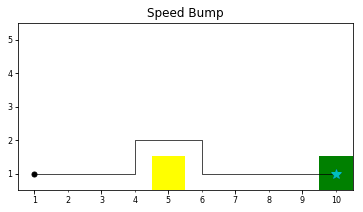

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00015.249238, w: [+0.00000000 +0.00000000 +0.00000000], dw: [-30.325757980 -4.903316975 +7.045819759], l2(dw): 31.51725959777832
Iter: 0001, loss: 00012.638173, w: [-0.30325758 -0.04903317 +0.07045820], dw: [+27.997516632 -51.335914612 +4.667969704], l2(dw): 58.6602668762207
Iter: 0002, loss: 00007.021715, w: [-0.29318166 -0.60603184 +0.17984569], dw: [-10.227447510 -1.707424164 +2.386985302], l2(dw): 10.640192031860352
Iter: 0003, loss: 00005.507843, w: [-0.38345599 -1.11834455 +0.30036581], dw: [-7.737951279 -0.316970587 +1.610979557], l2(dw): 7.910222053527832
Iter: 0004, loss: 00004.411161, w: [-0.53824782 -1.57141221 +0.42194006], dw: [-3.961260319 -0.101540916 +0.812592328], l2(dw): 4.0450215339660645
Done.


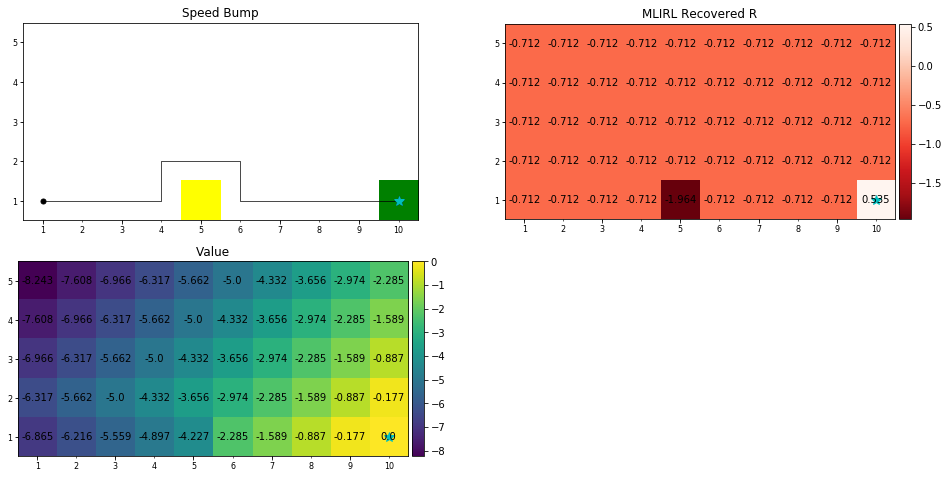

In [14]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 10.,
    w_init_scheme = "zeros",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
yi = 1
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', "yellow"],
    cell_locs = [np.inf, [(5,1)]],
    tau_s = [[(i,yi) for i in range(1,5)] + [(4,yi+1), (5,yi+1), (6,yi+1)] + [(i,yi) for i in range(6,11)]],
    goal_types=["green"],
    goal_locs=[(10,yi)],
)
irl_problem = dict(
    mdp_params, 
    title="Speed Bump",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), compute_new_value(results).round(3), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

Expected: R(green) = max(R), R(yellow) = min(R), Value function showing ripple effect

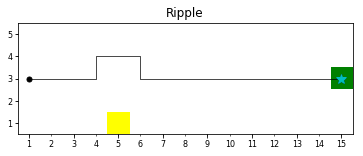

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00022.732960, w: [+0.00656065 +0.00904995 +0.00145475], dw: [-80.690399170 -1.830833554 -0.000000000], l2(dw): 80.71116638183594
Iter: 0001, loss: 00008.357168, w: [-0.80040896 -0.00934889 +0.00144020], dw: [-5.651803017 -0.147850648 -0.000000000], l2(dw): 5.653736591339111
Iter: 0002, loss: 00006.528206, w: [-1.57519555 -0.02729286 +0.00141271], dw: [-0.058518887 +0.011713211 -0.000000000], l2(dw): 0.05967963859438896
Iter: 0003, loss: 00007.031471, w: [-2.25733662 -0.04305237 +0.00137384], dw: [+1.386139870 -0.263531566 -0.000000000], l2(dw): 1.4109686613082886
Iter: 0004, loss: 00012.560692, w: [-2.83482885 -0.05944072 +0.00132511], dw: [+20.370288849 -57.704601288 -0.000000000], l2(dw): 61.194522857666016
Done.


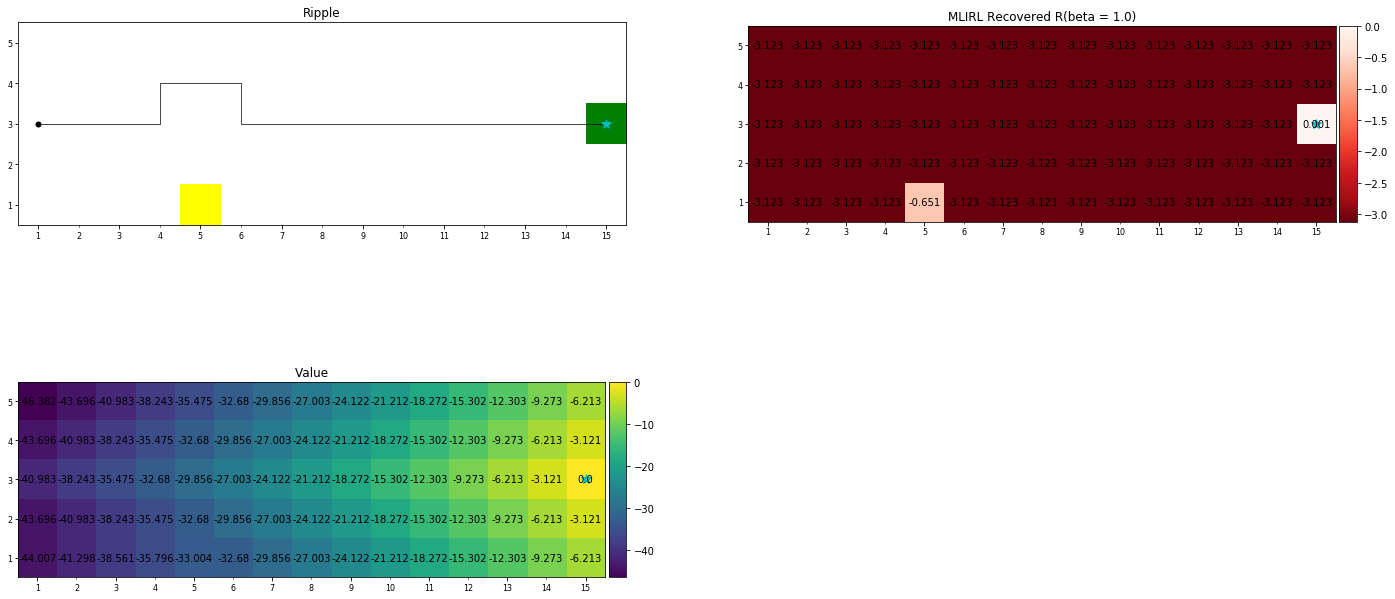

In [15]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.9999,
    boltzmann_beta = 1., # had to reduce
    w_init_scheme = "random",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.),
    goal_is_given=True,
)
yi = 3
mdp_params = dict(
    width = 15,
    height = 5,
    cell_types = ['white', "yellow"],
    cell_locs = [np.inf, [(5,1)]],
    tau_s = [[(i,yi) for i in range(1,5)] + [(4,yi+1), (5,yi+1), (6,yi+1)] + [(i,yi) for i in range(6,16)]],
    goal_types=["green"],
    goal_locs=[(15,yi)],
)
irl_problem = dict(
    mdp_params, 
    title="Ripple",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), compute_new_value(results).round(3), irl_problem["title"], 
                    rewards_cmap=plt.cm.Reds_r, r_fig_suffix="(beta = {})".format(mlirl_params["boltzmann_beta"]), figsize=(24,12))

### Suspicious Entry

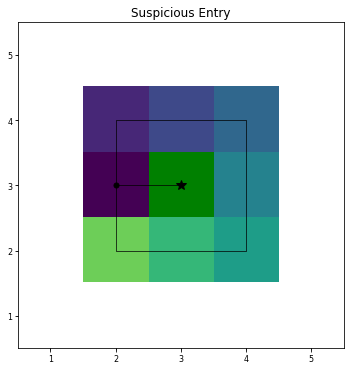

Training...
 				 	 white       green                 0           1           2           3           4           5           6           7  	 white       green                 0           1           2           3           4           5           6           7 
Iter: 0000, loss: 00012.476649, w: [+0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000], dw: [-5.610476494 +0.615166545 +0.550519884 +0.291671664 +0.899940014 +0.966011703 +1.132979274 +0.965731740 +0.899771512 +0.291325241], l2(dw): 6.090798854827881
Iter: 0001, loss: 00012.115559, w: [-0.05610476 +0.00615167 +0.00550520 +0.00291672 +0.00899940 +0.00966012 +0.01132979 +0.00965732 +0.00899772 +0.00291325], dw: [-5.276988029 +0.604984283 +0.498120040 +0.266921610 +0.861999333 +0.911249459 +1.103163362 +0.899633825 +0.855538011 +0.257116854], l2(dw): 5.738446235656738
Iter: 0002, loss: 00011.527535, w: [-0.15880789 +0.01767649 +0.01538603 +0.00818181 +0.0256288

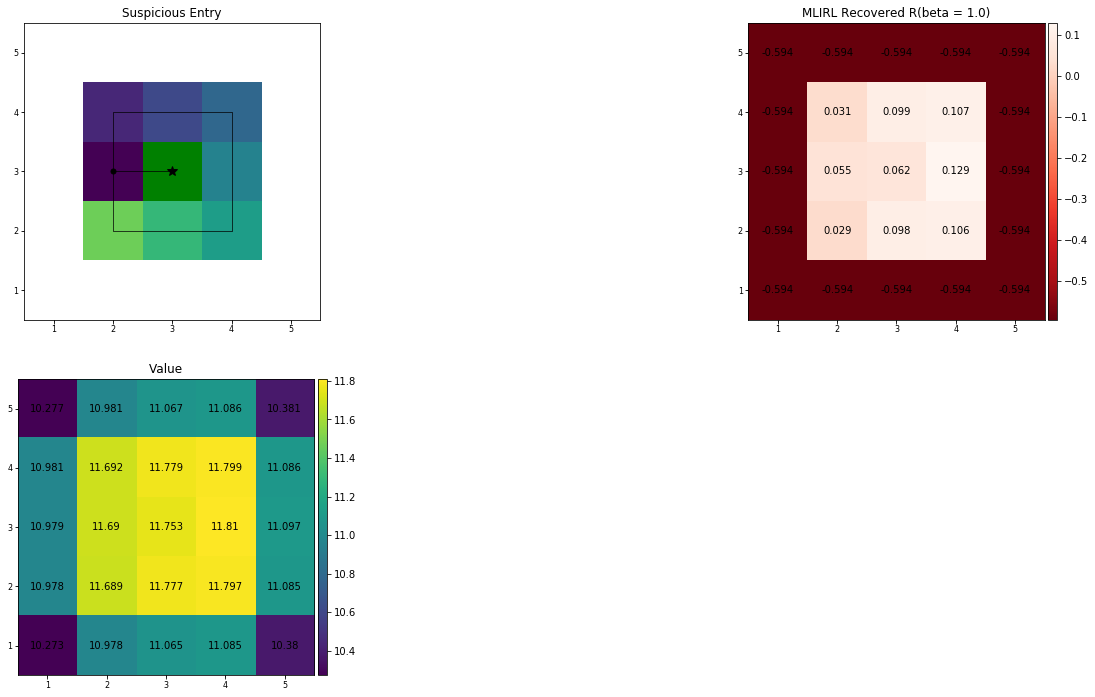

In [17]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.99,
    boltzmann_beta = 1.,
    w_init_scheme = "zeros",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"] + list(range(8)),
    cell_locs = [np.inf, [(3,3)], [(2,3)], [(2,4)], [(3,4)], [(4,4)], [(4,3)], [(4,2)], [(3,2)], [(2,2)]],
    tau_s = [[(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Suspicious Entry",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), compute_new_value(results).round(3), irl_problem["title"], 
                    rewards_cmap=plt.cm.Reds_r, r_fig_suffix="(beta = {})".format(mlirl_params["boltzmann_beta"]), figsize=(24,12))

### Walk

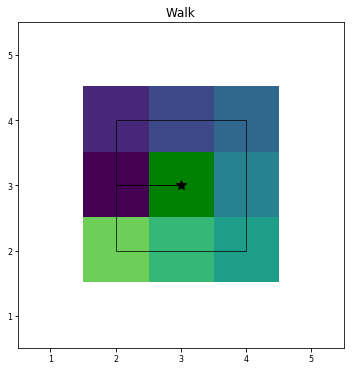

Training...
 				 	 white       green                 0           1           2           3           4           5           6           7  	 white       green                 0           1           2           3           4           5           6           7 
Iter: 0000, loss: 00013.862944, w: [+0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000 +0.00000000], dw: [-1.105789065 -0.027304977 +0.376588583 +0.097047776 +0.085068479 +0.151532277 +0.089208208 +0.151532292 +0.085068449 +0.097047776], l2(dw): 1.2052078247070312
Iter: 0001, loss: 00013.848436, w: [-0.01105789 -0.00027305 +0.00376589 +0.00097048 +0.00085068 +0.00151532 +0.00089208 +0.00151532 +0.00085068 +0.00097048], dw: [-1.103021860 -0.027735611 +0.376075655 +0.096797250 +0.084771670 +0.151314974 +0.088914491 +0.151315033 +0.084771596 +0.096797347], l2(dw): 1.2023600339889526
Iter: 0002, loss: 00013.821144, w: [-0.03192963 -0.00079342 +0.01087828 +0.00280218 +0.00245

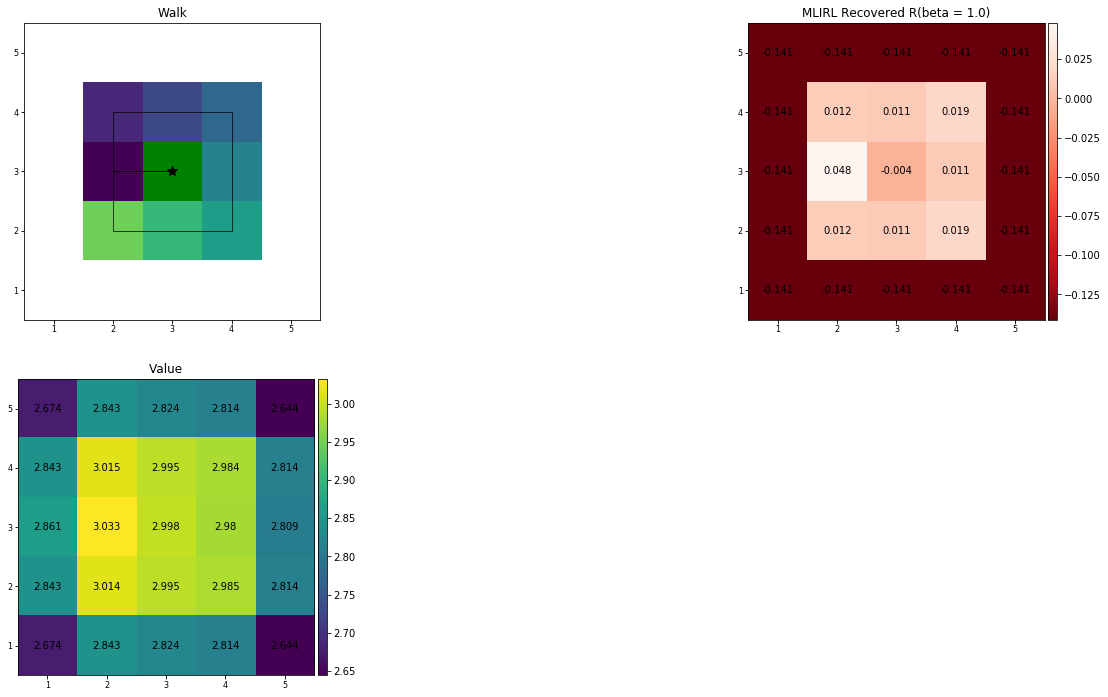

In [19]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    w_init_scheme = "zeros",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"] + list(range(8)),
    cell_locs = [np.inf, [(3,3)], [(2,3)], [(2,4)], [(3,4)], [(4,4)], [(4,3)], [(4,2)], [(3,2)], [(2,2)]],
    tau_s = [[(3,3),(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Walk",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), compute_new_value(results).round(3), irl_problem["title"], 
                    rewards_cmap=plt.cm.Reds_r, r_fig_suffix="(beta = {})".format(mlirl_params["boltzmann_beta"]), figsize=(24,12))

## Learning navigation costs

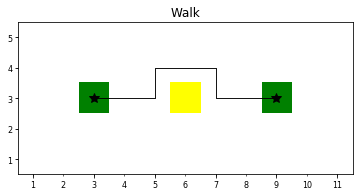

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00022.180714, w: [+0.00000000 +0.00000000 +0.00000000], dw: [-0.702877760 -0.335121274 +1.415048599], l2(dw): 1.615148901939392
Iter: 0001, loss: 00022.154713, w: [-0.00702878 -0.00335121 +0.01415049], dw: [-0.686984301 -0.341293812 +1.408772230], l2(dw): 1.6040785312652588
Iter: 0002, loss: 00022.106255, w: [-0.02015423 -0.00974673 +0.04083214], dw: [-0.656221390 -0.353597730 +1.395763159], l2(dw): 1.5823440551757812
Iter: 0003, loss: 00022.039362, w: [-0.03832781 -0.01894120 +0.07839493], dw: [-0.610890150 -0.372331589 +1.374080658], l2(dw): 1.549165964126587
Iter: 0004, loss: 00021.958506, w: [-0.06040966 -0.03075014 +0.12515831], dw: [-0.549597263 -0.397725403 +1.339325666], l2(dw): 1.5013446807861328
Done.


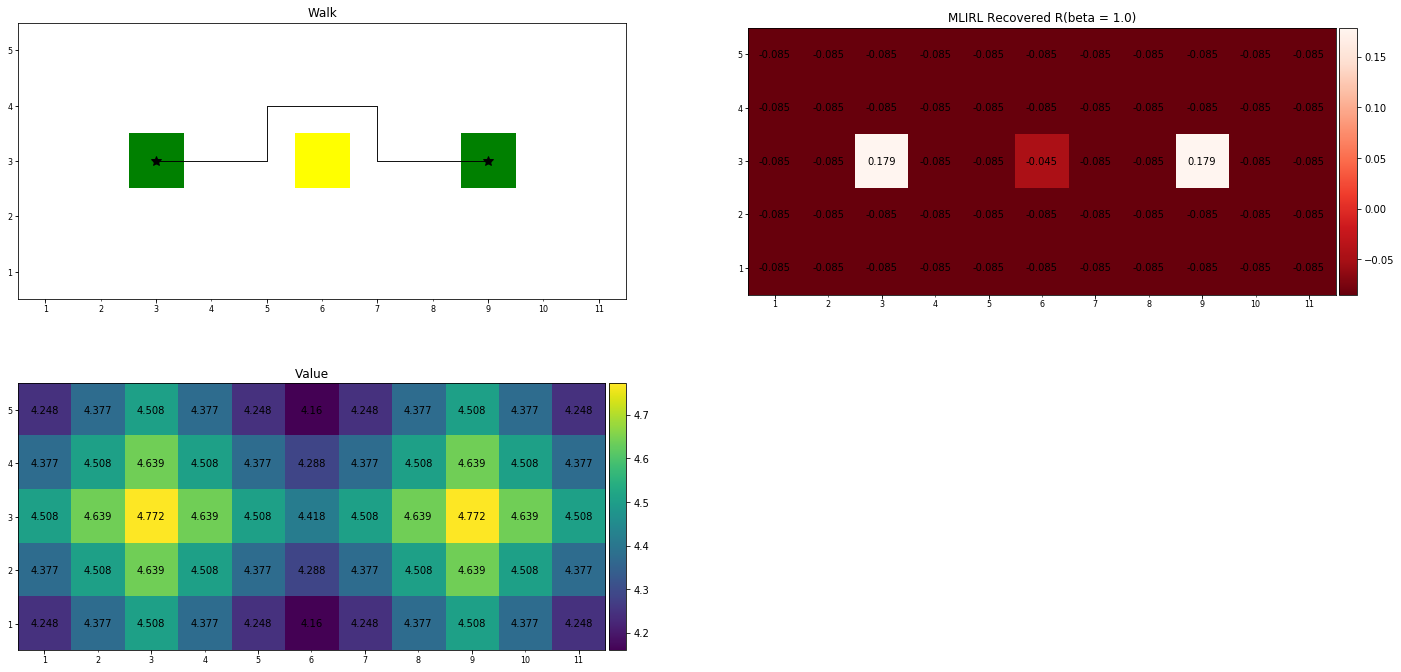

In [20]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.99,
    boltzmann_beta = 1.,
    w_init_scheme = "zeros",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.),
)
mdp_params = dict(
    width = 11,
    height = 5,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(6,3)],[(3,3), (9,3)]],
    tau_s = [[(3,3),(4,3),(5,3),(5,4),(6,4),(7,4),(7,3),(8,3),(9,3)], [(3,3),(4,3),(5,3),(5,4),(6,4),(7,4),(7,3),(8,3),(9,3)][::-1]],
)
irl_problem = dict(
    mdp_params, 
    title="Walk",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), compute_new_value(results).round(3), irl_problem["title"], 
                    rewards_cmap=plt.cm.Reds_r, r_fig_suffix="(beta = {})".format(mlirl_params["boltzmann_beta"]), figsize=(24,12))
# nvmdp = results["nvmdp"]
# inferred_rewards = np.array([nvmdp.cell_type_feature(i) for i in nvmdp.living_cell_ids]).dot(results["w"].data)
# nvmdp._reset_rewards(inferred_rewards.squeeze().tolist(), [])
# plt.imshow(nvmdp.get_value_grid())
# state_trajectories, action_trajectories = nvmdp.sample_data(n_trajectory=55,
#                                                             init_states=[GridWorldState(2,2)],
#                                                             init_repetition=False)
# nvmdp.visualize_grid(trajectories=state_trajectories, show_colorbar=True, show_rewards_colorbar=True, goal_marker="*c")

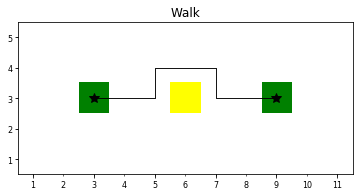

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00022.180714, w: [+0.00000000 +0.00000000 +0.00000000], dw: [-117.180465698 -2.449930668 -4.806043625], l2(dw): 117.3045654296875
Iter: 0001, loss: 00013.310258, w: [-1.17180467 -0.02449931 -0.04806044], dw: [+2.085238218 -1.793054342 -0.560929775], l2(dw): 2.806760549545288
Iter: 0002, loss: 00016.807432, w: [-2.20557642 -0.06447922 -0.09692413], dw: [+4.425485611 -1.506935120 -0.341771305], l2(dw): 4.687492370605469
Iter: 0003, loss: 00021.054579, w: [-3.09171629 -0.11553050 -0.14431915], dw: [+5.261303902 -1.556631088 -0.205550969], l2(dw): 5.490598201751709
Iter: 0004, loss: 00025.005714, w: [-3.83662891 -0.17704296 -0.18903019], dw: [+5.592035770 -1.672076225 -0.124751046], l2(dw): 5.838001728057861
Done.


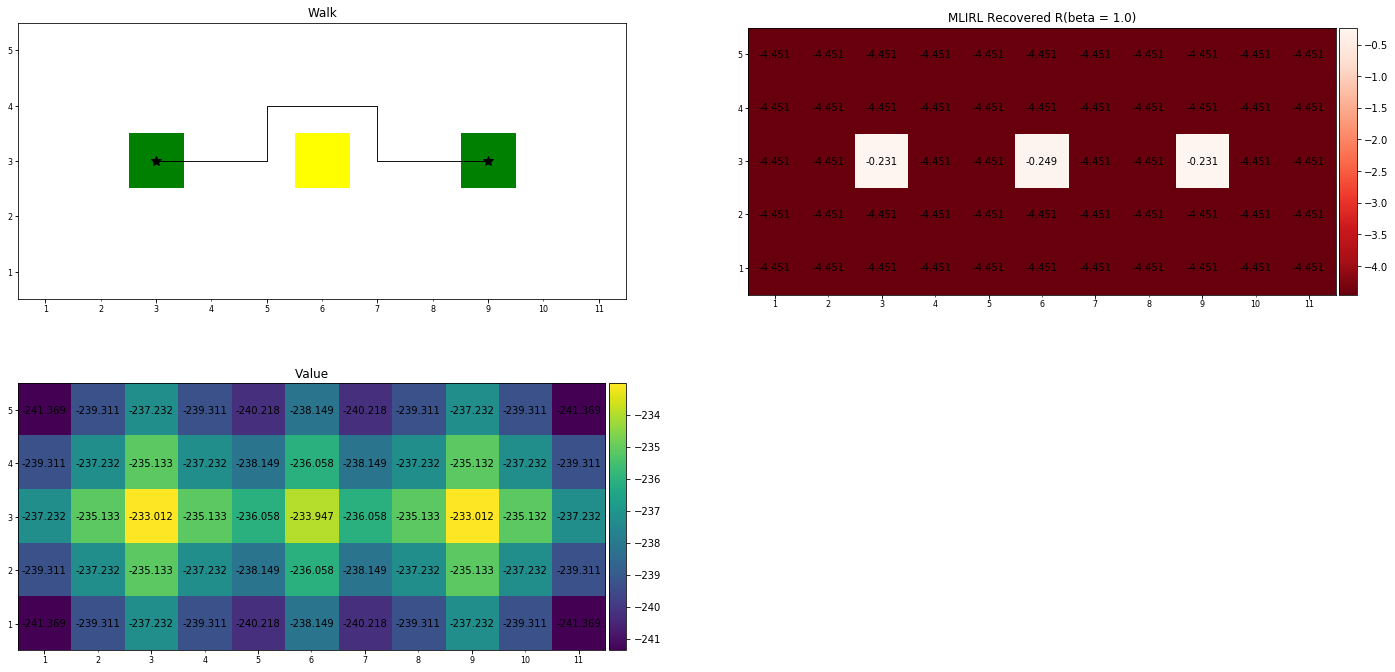

In [21]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 100,
    dtype = torch.float,
    gamma = 0.99,
    boltzmann_beta = 1.,
    w_init_scheme = "zeros",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.),
    goal_is_given=True
)
mdp_params = dict(
    width = 11,
    height = 5,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(6,3)],[(3,3), (9,3)]],
    tau_s = [[(3,3),(4,3),(5,3),(5,4),(6,4),(7,4),(7,3),(8,3),(9,3)], [(3,3),(4,3),(5,3),(5,4),(6,4),(7,4),(7,3),(8,3),(9,3)][::-1]],
)
irl_problem = dict(
    mdp_params, 
    title="Walk",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), compute_new_value(results).round(3), irl_problem["title"], 
                    rewards_cmap=plt.cm.Reds_r, r_fig_suffix="(beta = {})".format(mlirl_params["boltzmann_beta"]), figsize=(24,12))

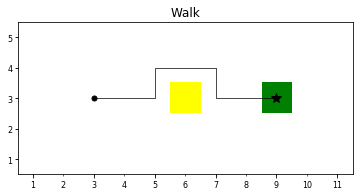

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00011.090355, w: [+0.00000000 +0.00000000 +0.00000000], dw: [-32.011737823 -3.467759371 -0.000000000], l2(dw): 32.19901657104492
Iter: 0001, loss: 00007.797543, w: [-0.32011738 -0.03467759 +0.00000000], dw: [+9.618773460 -9.237633705 -0.000000000], l2(dw): 13.336216926574707
Iter: 0002, loss: 00009.152073, w: [-0.50883412 -0.15791698 +0.00000000], dw: [+15.039438248 -8.509804726 -0.000000000], l2(dw): 17.280088424682617
Iter: 0003, loss: 00007.779857, w: [-0.52319646 -0.35235131 +0.00000000], dw: [+14.095127106 -7.959402084 -0.000000000], l2(dw): 16.187177658081055
Iter: 0004, loss: 00004.397264, w: [-0.38993934 -0.60341275 +0.00000000], dw: [+2.839415550 -3.877828598 -0.000000000], l2(dw): 4.8062286376953125
Done.


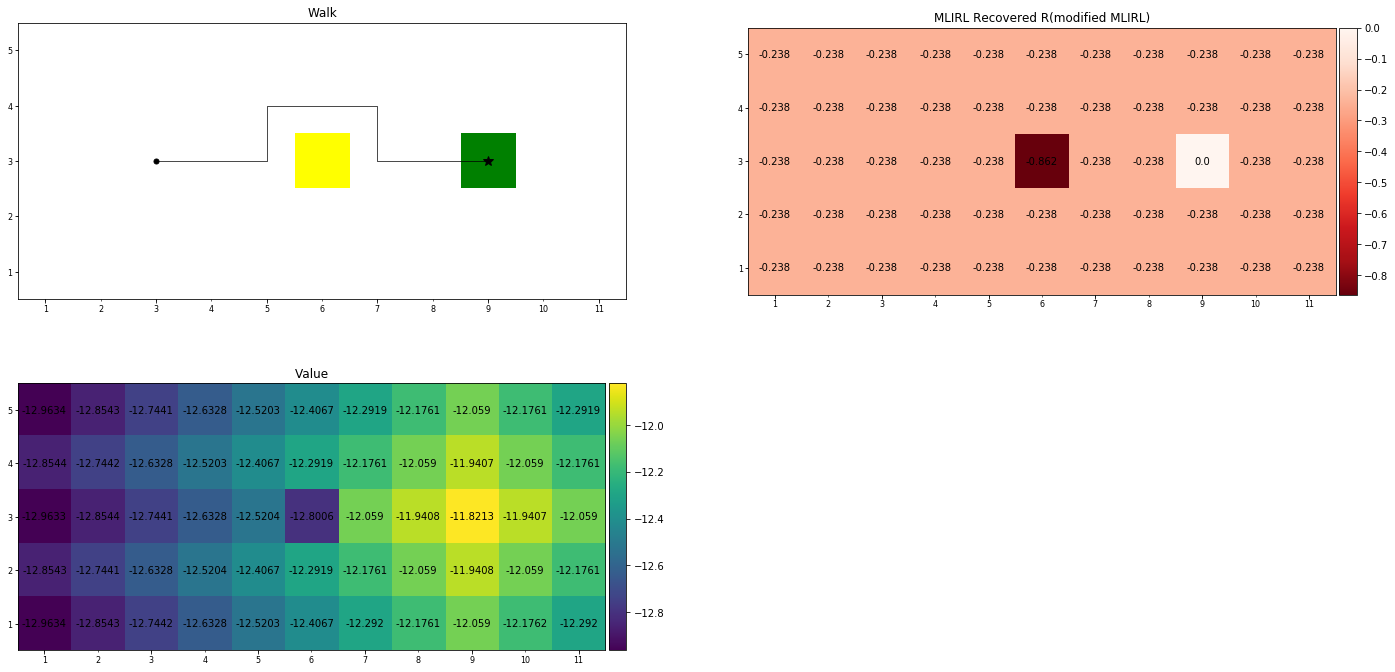

In [23]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 20,
    dtype = torch.float,
    gamma = 0.8,
    boltzmann_beta = 10.,
    w_init_scheme = "zeros",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.),
    goal_is_given=True
)
mdp_params = dict(
    width = 11,
    height = 5,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(6,3)],[(9,3)]],
    tau_s = [[(3,3),(4,3),(5,3),(5,4),(6,4),(7,4),(7,3),(8,3),(9,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Walk",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)


np.random.seed(0)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
# We get different V_grid for each goal, so ignore this visualization

display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), compute_new_value(results).round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r, 
                    figsize=(24,12), r_fig_suffix="(modified MLIRL)")

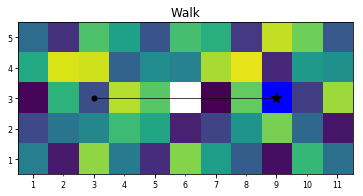

Training...
 				 	 white       blue                  0           1           2           3           4           5           6           7           8           9          10          11          12          13          14          15          16          17          18          19          20          21          22          23          24          25          26          27          28          29          30          31          32          33          34          35          36          37          38          39          40          41          42          43          44          45          46          47          48          49          50          51          52  	 white       blue                  0           1           2           3           4           5           6           7           8           9          10          11          12          13          14          15          16          17          18          19          20          21          22          23      

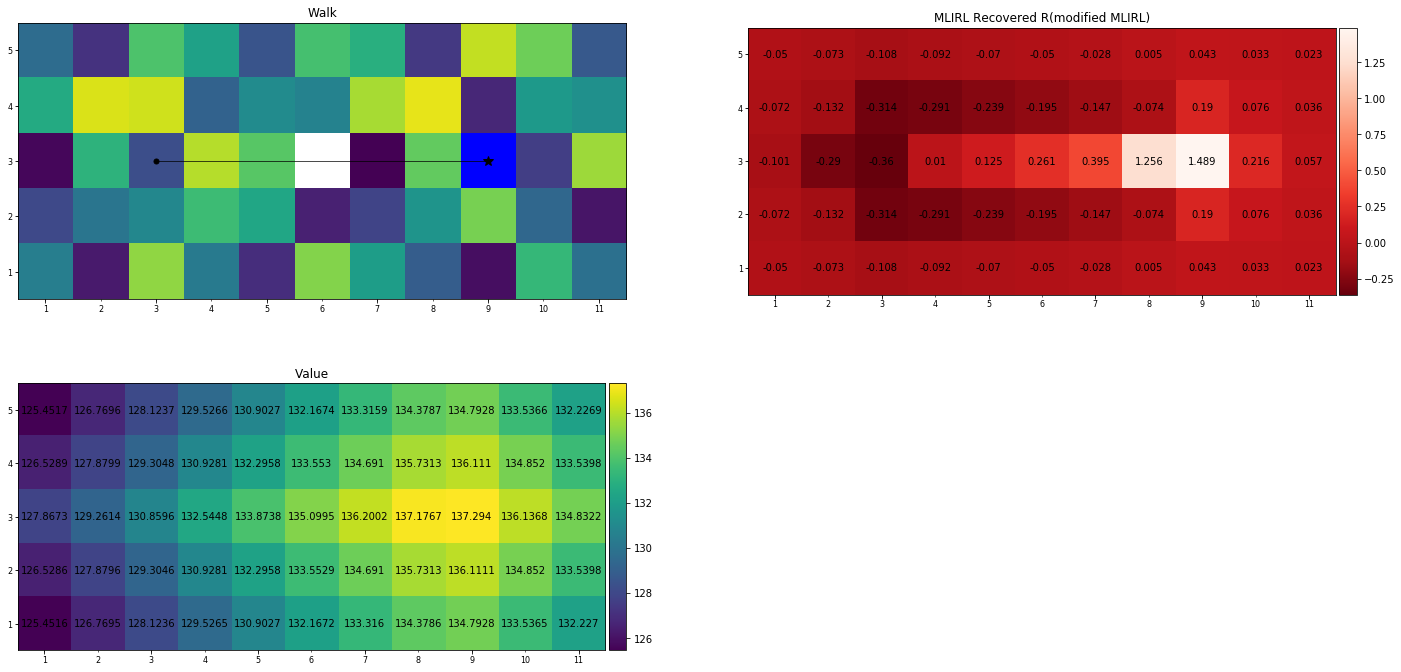

In [24]:
mlirl_params = dict(
    n_iter = 10,
    n_vi_iter = 20,
    dtype = torch.float,
    gamma = 0.8,
    boltzmann_beta = 10.,
    w_init_scheme = "zeros",
    grad_eps = 1e-3,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
background = set((x,y) for x in range(1,12) for y in range(1,6))
background.difference_update([(6,3), (9,3)])
mdp_params = dict(
    width = 11,
    height = 5,
    cell_types = ["white", "blue"] + list(range(len(background))),
    cell_locs = [[(6,3)],[(9,3)]] + list(([x] for x in background)),
    tau_s = [[(3,3),(4,3),(5,3),(6,3),(7,3), (8,3),(9,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Walk",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
np.random.seed(0)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), compute_new_value(results).round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r, 
                    figsize=(24,12), r_fig_suffix="(modified MLIRL)")

# References

[1] Babes, Monica, et al. "Apprenticeship learning about multiple intentions." Proceedings of the 28th International Conference on Machine Learning (ICML-11). 2011.  